# Tarea 3: Aprendizaje de Máquinas

### Autor: Arturo Lazcano

#### Profesor: Felipe Tobar
#### Auxiliares: Catherine Benavides, Camila Bergasa, Víctor Caro, Camilo Carvajal, Diego Cortéz y Stefano Schiappacasse

### Importación Librerías



In [2]:
# Librerías principales
#!pip install --upgrade pandas
import pandas as pd
import numpy as np
import math
import random
import torch
import os
from PIL import Image
from IPython.display import display, Markdown, Latex

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

# Pytorch
from torch.nn.functional import binary_cross_entropy_with_logits, cross_entropy
from torch import nn
from torch import optim

# Keras
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical

# Gráficos
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
!pip install --upgrade plotly
import plotly.express as px

# Alertas
import warnings
warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 93.6 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1


Nota: Las semillas no funcionan como deberían, es por esto que los graficos de este notebook podrían llegar a diferir un poco con respecto al informe o tener diferencias como por ejemplo el color de los clusters, sin embargo, esto debería ser en mínima medida. Las conclusiones seguirán siendo las mismas.

## P1: Clustering y reducción de dimensionalidad

### Importación Base de Datos

Al trabajar en google colab, se suben los archivos `images.zip` y `test.zip`, es decir, los archivos comprimidos y se ejecuta el siguiente código para descomprimirlos y luego poder leerlos. Otra opción es leerlos desde drive con el código que está comentado.
Nota: no pude cargar las carpetas a colab, por eso se comprimen y se suben en .zip

In [3]:
# Conectar a Drive para leer bbdd MNIST
try:
    from google.colab import drive
    drive.mount("/content/drive")
    path = 'Dirección donde tiene los archivos en el Drive'
except:
    print('Ignorando conexión drive-colab')

Mounted at /content/drive


In [ ]:
!unzip /content/images.zip
!unzip /content/test.zip

In [5]:
# ------------------------- BBDD de caras --------------------------#

# Imagenes de entrenamiento
path = "./images/"
img_names = os.listdir(path)
img_names.sort()
imgs = np.array(list(map(lambda img: np.array(Image.open(path + img)), img_names)))

# Imagenes de prueba
path = "./test/"
img_names = os.listdir(path)
img_names.sort()
test_images = np.array(list(map(lambda img: np.array(Image.open(path + img)), img_names)))

# Pasamos cada imágen a formato vector
data = imgs.reshape(5000, 44*28)

# Pasamos cada imágen de test a formato vector
data_test = test_images.reshape(5, 44*28)

print('Data de entrenamiento: \n', data)
print('---------------------------------------')
print('Data de prueba: \n', data_test)

Data de entrenamiento: 
 [[ 28  31  67 ...  71  54  43]
 [ 29  56  93 ... 131 100  75]
 [ 53  56  49 ... 120 103  97]
 ...
 [112 133 158 ...  49  48  52]
 [ 21  13  11 ... 102  84  78]
 [ 90  81 111 ...  23  38  54]]
---------------------------------------
Data de prueba: 
 [[173 154 175 ...  97  98  99]
 [ 88  81  98 ... 111  93 195]
 [160 150 143 ... 103 103 103]
 [172 175 173 ...   7  14  16]
 [ 93 102 255 ...  53 176 188]]


In [6]:
# ------------------------- BBDD de fasion MNIST --------------------------#

# Leer conjunto de entrenamiento de fashion MNIST
train = pd.read_csv("/content/drive/MyDrive/fashion-mnist_train.csv")
y_train = train['label'].values
x_train = train[list(train.columns)[1:]].values

# conjunto de otras dimensiones para la última pregunta
x_train_reshape = x_train.reshape(-1, 28,28, 1)
x_train_reshape = x_train_reshape / 255

x_train = x_train.reshape(-1, 784)
x_train = x_train / 255

# Leer conjunto de prueba de fashion MNIST
test = pd.read_csv("/content/drive/MyDrive/fashion-mnist_test.csv")
y_test = test['label'].values
x_test = test[list(test.columns)[1:]].values
x_test = x_test / 255

# conjunto de otras dimensiones para la última pregunta
x_test_reshape = x_test.reshape(-1, 28,28, 1)
x_test_reshape = x_test_reshape / 255

x_test = x_test.reshape(-1, 784)
x_test = x_test / 255

In [7]:
# Pequeño EDA de bbdd de caras
print('Mini EDA base de datos de caras: \n')

print('Hay',len(data),'imagenes de entrenamiento')
print('Hay',len(test_images),'imagenes de prueba')
print('------------------------------------')
print('El valor máximo de un pixel es', data.max())
print('El valor mínimo de un pixel es', data.min())
print('------------------------------------')
print('El largo de cada canal es de', len(imgs[0][0]))
print('El total de canales es de', len(imgs[0]))
print('El largo de los vectores es de', len(data[0]))

Mini EDA base de datos de caras: 

Hay 5000 imagenes de entrenamiento
Hay 5 imagenes de prueba
------------------------------------
El valor máximo de un pixel es 255
El valor mínimo de un pixel es 0
------------------------------------
El largo de cada canal es de 28
El total de canales es de 44
El largo de los vectores es de 1232


In [8]:
# Pequeño EDA de bbdd de fasion MNIST
print('Mini EDA base de datos fashion MNIST: \n')

print('El conjunto de x_train es de dimensión', x_train.shape)
print('El conjunto de y_train es de dimensión', y_test.shape)
print('------------------------------------------------------------------------')
print('El conjunto de x_test es de dimensión', x_test.shape)
print('El conjunto de y_test es de dimensión', y_train.shape)
print('------------------------------------------------------------------------')
print('Las clases vienen dadas por el conjunto', np.unique(y_test).tolist())
print('El valor mínimo y máximo en el conjunto de entrenamiento es', [x_train.min().tolist(), x_train.max().tolist()])

Mini EDA base de datos fashion MNIST: 

El conjunto de x_train es de dimensión (60000, 784)
El conjunto de y_train es de dimensión (10000,)
------------------------------------------------------------------------
El conjunto de x_test es de dimensión (10000, 784)
El conjunto de y_test es de dimensión (60000,)
------------------------------------------------------------------------
Las clases vienen dadas por el conjunto [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
El valor mínimo y máximo en el conjunto de entrenamiento es [0.0, 1.0]


### (a)

In [9]:
# Normalizar datos (opcional, se hace pues es muy común para realizar PCA)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
data_test = scaler.fit_transform(data_test)

# Inicializar PCA
pca = PCA(n_components = 10)
X_pca = pca.fit_transform(data) #data_norm

# Ver componentes principales (forma vectorial)
for i in range(10):
  print(f'PC{i+1}:', pca.components_[i])
  if i==9:
    print('\n')
    print('Media de las componentes:', pca.mean_)

PC1: [-0.02036971 -0.02217274 -0.02447324 ... -0.01553858 -0.01410884
 -0.01221962]
PC2: [ 0.0306322   0.03223464  0.03243738 ... -0.03766823 -0.03777706
 -0.03748186]
PC3: [-0.05965864 -0.06424096 -0.06901722 ...  0.01059249  0.00740709
  0.00526045]
PC4: [0.04392366 0.04044749 0.03312362 ... 0.06958651 0.07094279 0.06971673]
PC5: [-0.05048476 -0.05455751 -0.05877575 ... -0.03296881 -0.03033978
 -0.02822117]
PC6: [0.01389055 0.02315039 0.03307623 ... 0.07481731 0.07462088 0.06919833]
PC7: [-0.0399619  -0.04301849 -0.04184362 ...  0.01005887  0.00246207
 -0.00383428]
PC8: [ 0.06396593  0.07099956  0.07418355 ... -0.02090084 -0.02639798
 -0.02852524]
PC9: [-0.05860395 -0.06024238 -0.06018748 ...  0.07045188  0.07075608
  0.06614831]
PC10: [-0.00469359 -0.0038509  -0.00353865 ... -0.0210282  -0.02262186
 -0.02379323]


Media de las componentes: [0.40612392 0.42166588 0.44215922 ... 0.3891851  0.38463843 0.38076706]


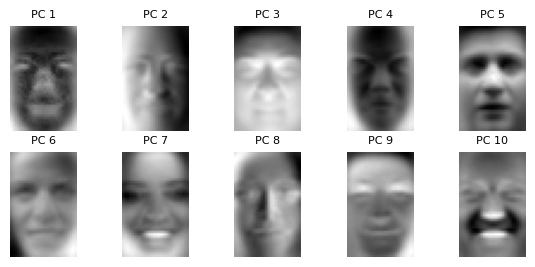

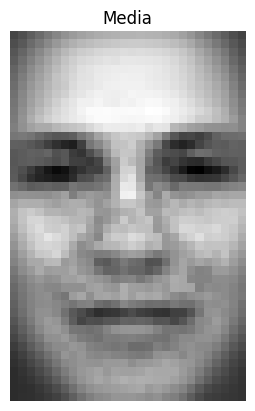

In [10]:
# Imagen pequeña de las PC pasadas a escala de gris
fig, axes = plt.subplots(2, 5, figsize = (7,3))

# Mostramos cada vector propio
for i, ax in enumerate(axes.flatten()):
    ax.imshow(pca.components_[i].reshape(44,28), cmap = "gray")
    ax.set_title(f'PC {i+1}', fontsize=8)
    ax.axis("off")
plt.show()

# Media
plt.imshow(np.mean(data, axis=0).reshape(44,28), cmap="gray")
plt.axis('off')
plt.title('Media')
plt.show()

In [38]:
# Ver componentes principales con otra escala de colores y más grande para ver mayor definición
for i in range(10):
  foto = pca.components_[i].reshape(44,28)
  fig = px.imshow(foto, title=f'Componente principal {i+1}')
  fig.show()
  if i==9:
    foto_mean = pca.mean_.reshape(44,28)
    fig = px.imshow(foto_mean, title='Media de las PC')
    fig.show()

Acá se puede observar como se ven las 10 componentes principales entregadas por el algoritmo `PCA`, reordenando su output como imagen para poder graficarlo.
Se observa que cada componente principal se enfoca en ciertas partes de las caras o de la foto en general. Por ejemplo, se puede ver como la comp. principal 2 le da más importancia (color) al lado izquierdo de la foto mientras que la comp. principal 3 le da importancia todo menos la frente (y la nariz ligeramente). Así, se puede ver como cada componente principal se enfoca en una parte distinta de la cara o foto.

Por otro lado, la media de los datos se ve en la última imagen, donde los píxeles más oscuros están relacionados a los ojos, boca, un poco la nariz y la parte externa de la foto que no pertenece a la cara.

### (b)

In [12]:
# Parámetros a usar
mses = []
#n_components = [2, 5, 10, 20, 35, 60, 100, 150, 200, 250, 300, 400, 500, 600, 700, 900, 1000, 1100, 1200, 1232]
n_components = list(np.linspace(2, 1232, 10).astype(int))

# Entrenar modelo PCA con todas las PC
pca_full = PCA(n_components = 1232)
X_pca_full = pca_full.fit_transform(data)

#-------------------------------- Conjunto de entrenamiento ----------------------------------#

for n_pc in n_components:
  # Recomponer fotos
  recomposicion = X_pca_full[:, :n_pc] @ pca_full.components_[:n_pc] + np.mean(data, axis=0)
  # Raíz del error cuadrático medio
  mse = mean_squared_error(data, recomposicion, squared=False)
  mses.append(mse)

In [13]:
#-------------------------------- Conjunto de prueba ----------------------------------#
mses_test = []

for i in range(len(data_test)):
  mse_test = []
  for n_pc in n_components:
    # Recomponer foto
    recomposicion_test = (pca_full.transform(data_test)[i, :n_pc] @ pca_full.components_[:n_pc, :])
    recomposicion_test = recomposicion_test + np.mean(data, axis=0) # pca_full.mean_
    # Raíz del error cuadrático medio
    mse = mean_squared_error(data_test[i], recomposicion_test, squared=False)
    mse_test.append(mse)
  mses_test.append(mse_test)

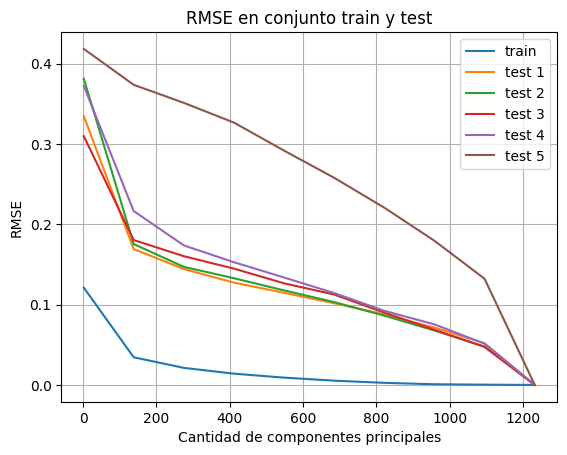

In [14]:
# Graficar RMSE para conjunto de train
plt.plot(n_components, np.array(mses), label='train')
# Graficar RMSE para conjunto de test por separado
for i in range(len(mses_test)):
  plt.plot(n_components, np.array(mses_test[i]), label=f'test {i+1}')
plt.title('RMSE en conjunto train y test')
plt.ylabel('RMSE')
plt.xlabel('Cantidad de componentes principales')
plt.grid()
plt.legend()
plt.show()

### (c)

In [15]:
# Definir pixeles asociados a la boca
data_boca = np.array([sublist.reshape(44,28)[30:40, 5:23] for sublist in data])
data_boca = data_boca.reshape(5000, 10*18)

# Iniciaizar K-means
kmeans = KMeans(n_clusters=20, random_state=20470051)
# Entrenar
kmeans.fit(data_boca)

KMeans(n_clusters=20, random_state=20470051)

In [16]:
# Calcular media de las bocas por cada cluster
medias_boca = []
for i in range(20):
  # indices de data_boca que pertenecen a un mismo cluster
  idx_mismo_cluster = np.where(kmeans.labels_==i)
  # calcular media por cluster
  media = np.mean(data_boca[idx_mismo_cluster], axis=0)
  medias_boca.append(media)

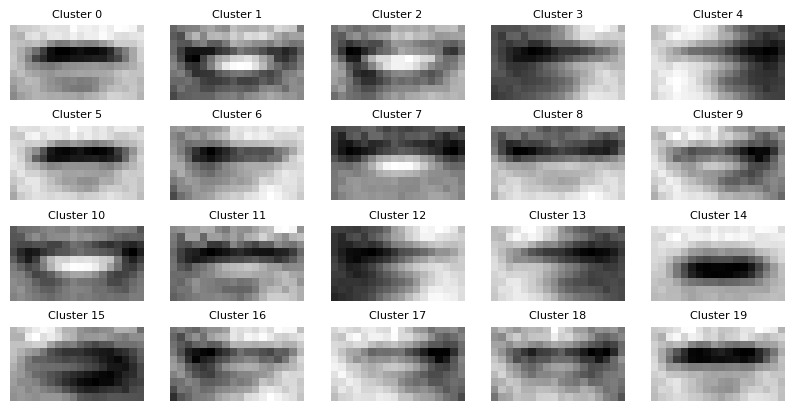

In [17]:
# Imagen pequeña de las medias de las bocas por cluster pasadas a escala de gris
fig, axes = plt.subplots(4, 5, figsize = (10,5))

# Mostramos cada vector propio
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.array(medias_boca[i]).reshape(10,18), cmap = "gray")
    ax.set_title(f'Cluster {i}', fontsize=8)
    ax.axis("off")
plt.show()

In [18]:
# Calcular media de las caras por cada cluster
medias_cara = []
for i in range(20):
  # indices de data_boca que pertenecen a un mismo cluster
  idx_mismo_cluster = np.where(kmeans.labels_==i)
  # calcular media por cluster
  media = np.mean(data[idx_mismo_cluster], axis=0)
  medias_cara.append(media)

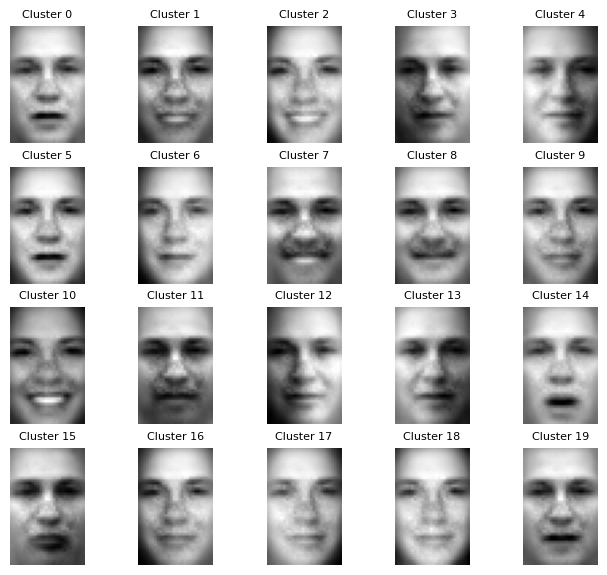

In [19]:
# Imagen pequeña de las medias de las caras por cluster pasadas a escala de gris
fig, axes = plt.subplots(4, 5, figsize = (8,7))

# Mostramos cada vector propio
for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.array(medias_cara[i]).reshape(44,28), cmap = "gray")
    ax.set_title(f'Cluster {i}', fontsize=8)
    ax.axis("off")
plt.show()

In [20]:
# Imagenes más detalladas de la boca con plotly
for i in range(len(medias_boca)):
  foto_medias = np.array(medias_boca[i]).reshape(10,18)
  fig = px.imshow(foto_medias, title=f'Media del cluster {i}')
  fig.show()

In [21]:
# Imagenes más detalladas de la cara con plotly
for i in range(len(medias_cara)):
  foto_medias = np.array(medias_cara[i]).reshape(44,28)
  fig = px.imshow(foto_medias, title=f'Media del cluster {i}')
  fig.show()

In [22]:
# Se elige el cluster
eleccion = 2
idx_cluster = np.where(kmeans.labels_==eleccion)
cluster = data[idx_cluster[0]]
print('Hay', len(cluster), f'fotos en el cluster {eleccion}: \n')
cluster

Hay 184 fotos en el cluster 2: 



array([[0.3254902 , 0.48235294, 0.59215686, ..., 0.74117647, 0.72941176,
        0.70980392],
       [0.67058824, 0.56862745, 0.34509804, ..., 0.3254902 , 0.36862745,
        0.42745098],
       [0.50588235, 0.53333333, 0.56862745, ..., 0.53333333, 0.43137255,
        0.4627451 ],
       ...,
       [0.16078431, 0.19607843, 0.17254902, ..., 0.54901961, 0.50980392,
        0.48627451],
       [0.40784314, 0.41960784, 0.43921569, ..., 0.38823529, 0.3372549 ,
        0.32156863],
       [0.65098039, 0.68627451, 0.6745098 , ..., 0.35294118, 0.30196078,
        0.27058824]])

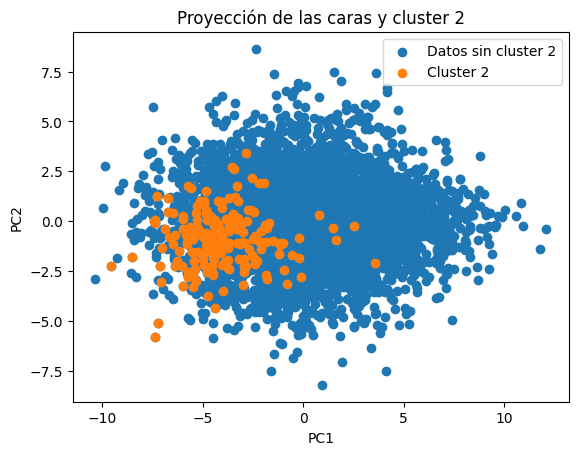

In [23]:
# Scatterplot de datos con cluster elegido
plt.scatter(*X_pca_full[:,:2].T, label=f'Datos sin cluster {eleccion}') # En verdad están pero se sobreescriben
plt.scatter(*X_pca_full[idx_cluster[0], :2].T, label=f'Cluster {eleccion}')
plt.title(f'Proyección de las caras y cluster {eleccion}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(loc='upper right')
plt.show()

In [24]:
# Calcular medias de cluster y datos para luego restarlos
media_cluster = np.mean(cluster, axis=0)
media_datos = np.mean(data, axis=0)
resta_medias = media_cluster - media_datos

In [25]:
# Redefinir componente principal por resta de medias
pca_full.components_[1] = pca_full.components_[0]
pca_full.components_[0] = resta_medias
# Transformar data
new_pca = pca_full.transform(data)

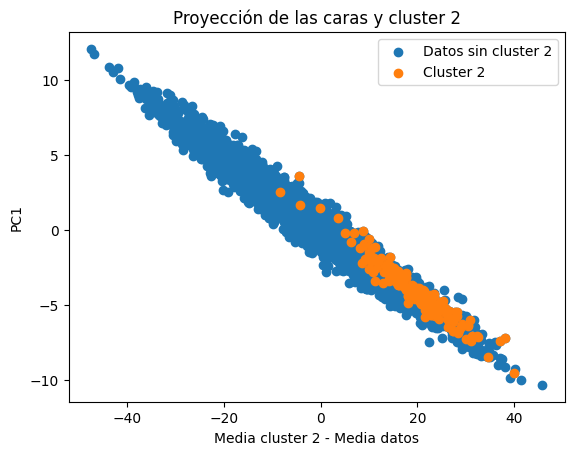

In [26]:
# Scatterplot de datos con cluster elegido
plt.scatter(*new_pca[:,:2].T, label=f'Datos sin cluster {eleccion}') # En verdad están pero se sobreescriben
plt.scatter(*new_pca[idx_cluster[0], :2].T, label=f'Cluster {eleccion}')
plt.title(f'Proyección de las caras y cluster {eleccion}')
plt.xlabel(f'Media cluster {eleccion} - Media datos')
plt.ylabel('PC1')
plt.legend()
plt.show()

### (d)

In [27]:
# Concatenar datos de todo el dataset para graficar después
X = np.append(x_train,x_test, axis=0)
y = np.append(y_train,y_test, axis=0)

In [28]:
# --------------------- K-means --------------------#

# Iniciaizar K-means
kmeans_2 = KMeans(n_clusters=10, random_state=20470051)
# Entrenar
X_ft = kmeans_2.fit_transform(x_train)

In [29]:
# --------------------- PCA ---------------------#

# Normalizar datos
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(x_train)

# Inicializar PCA
pca_ft = PCA(n_components = 2, random_state=20470051)
X_pca_ft = pca_ft.fit_transform(X_norm)

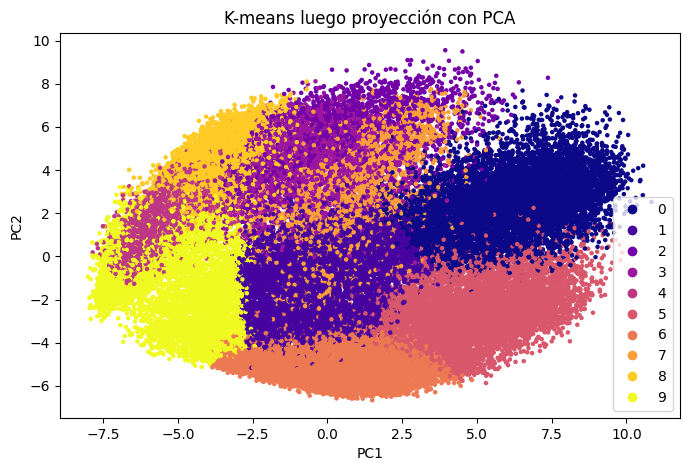

In [30]:
# Centroides y tamaño de imagen
centroids = kmeans_2.cluster_centers_
plt.figure(figsize=(8,5))
# Graficar kmeans_2 luego de haber hecho PCA
g = plt.scatter(X_pca_ft[:, 0], X_pca_ft[:, 1], c=kmeans_2.labels_, cmap='plasma', s=5)
plt.legend(*g.legend_elements())
plt.title('K-means luego proyección con PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [31]:
# --------------------- PCA ---------------------#

# Inicializar PCA
pca_d = PCA(n_components = 2, random_state=20470051)
X_pca_d = pca_d.fit_transform(X_norm)

In [32]:
# --------------------- K-means --------------------#

# Iniciaizar K-means
kmeans_3 = KMeans(n_clusters=10, random_state=20470051)
# Entrenar
kmeans_3.fit(X_pca_d)

KMeans(n_clusters=10, random_state=20470051)

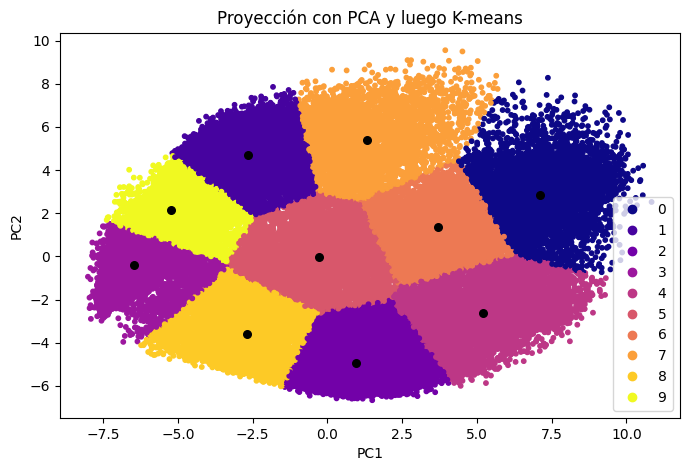

In [33]:
# labels, centroides y tamaño de imagen
label = kmeans_3.fit_predict(X_pca_d)
u_labels = np.unique(label)
centroids = kmeans_3.cluster_centers_
plt.figure(figsize=(8,5))
# Graficar kmeans_3 luego de haber hecho PCA
g = plt.scatter(X_pca_d[:, 0], X_pca_d[:, 1], c=kmeans_3.labels_, cmap='plasma', s=10)
plt.legend(*g.legend_elements())
plt.scatter(centroids[:,0] , centroids[:,1] , s = 30, color = 'k')
plt.title('Proyección con PCA y luego K-means')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

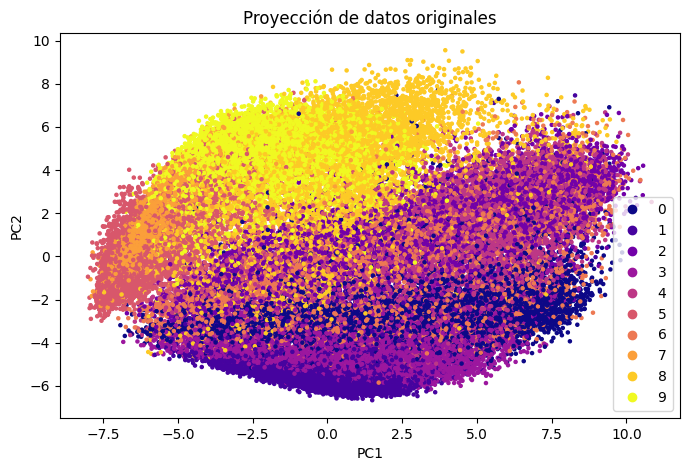

In [34]:
# labels y tamaño de imagen
plt.figure(figsize=(8,5))
# Graficar kmeans_2 luego de haber hecho PCA
g = plt.scatter(X_pca_d[:, 0], X_pca_d[:, 1], c=y_train, cmap='plasma', s=5)
plt.legend(*g.legend_elements())
plt.title('Proyección de datos originales')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

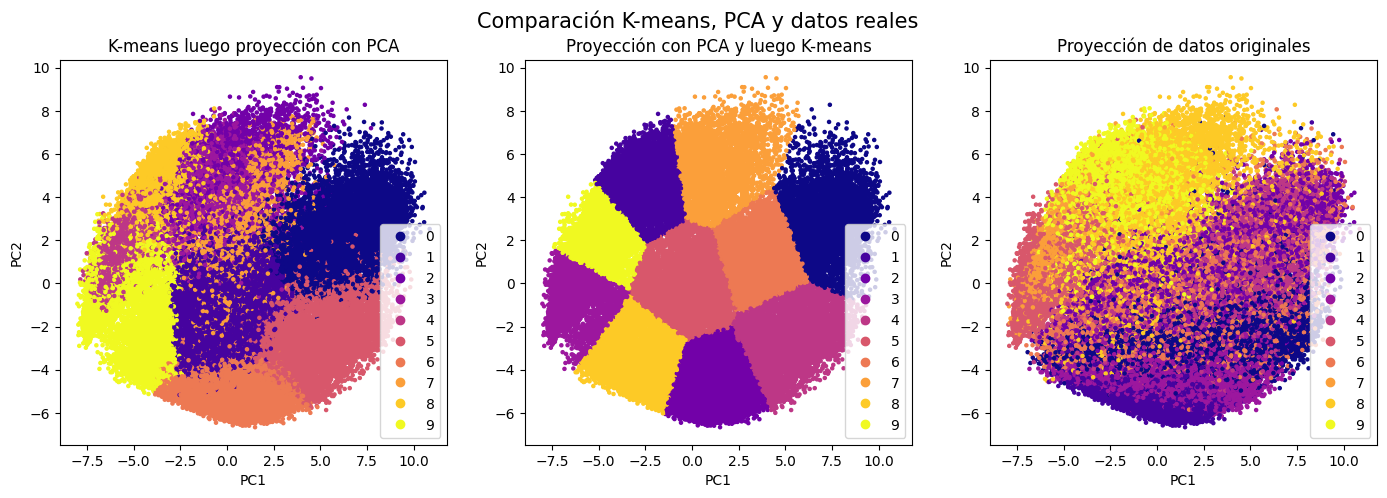

In [35]:
# Graficar los 3 juntos para comparar
fig, axes = plt.subplots(1, 3, figsize=(17,5))
fig.suptitle('Comparación K-means, PCA y datos reales', fontsize=15)
g1 = axes[0].scatter(X_pca_ft[:, 0], X_pca_ft[:, 1], c=kmeans_2.labels_, cmap='plasma', s=5)
g2 = axes[1].scatter(X_pca_d[:, 0], X_pca_d[:, 1], c=kmeans_3.labels_, cmap='plasma', s=5)
g3 = axes[2].scatter(X_pca_d[:, 0], X_pca_d[:, 1], c=y_train, cmap='plasma', s=5)
axes[0].set_title('K-means luego proyección con PCA')
axes[1].set_title('Proyección con PCA y luego K-means')
axes[2].set_title('Proyección de datos originales')
for i in [0,1,2]:
  axes[i].set_xlabel('PC1')
  axes[i].set_ylabel('PC2')
axes[0].legend(*g1.legend_elements())
axes[1].legend(*g2.legend_elements())
axes[2].legend(*g3.legend_elements())
plt.show()

## P2: Redes neuronales

### (c)

In [ ]:
# Convertir a tensor
x_train, y_train = map(torch.tensor, (x_train, y_train))
x_train = x_train.float()

x_test, y_test = map(torch.tensor, (x_test, y_test))
x_test = x_test.float()

In [ ]:
# Función de la clase auxiliar

logsoftmax = torch.nn.LogSoftmax(dim=0)

def predicciones(output):
  """Realiza las predicciones mediante la función logsoftmax
  """
  return torch.argmax(logsoftmax(output),axis=1)

In [ ]:
# Se definen fuera los pesos para poder comparar los 2 métodos siguientes
pesos_in = torch.randn((784, 10))
sesgo_in = torch.zeros(10, requires_grad=True)

In [ ]:
def DescensoGradiente(pesos, sesgo, tasa, batch_size):
  """Realiza el entrenamiento de una regresión logística mediante
    el método de descenso de gradiente mini batch.

  Parameters
  ----------
  pesos : torch.tensor
    Pesos del modelo

  sesgo : torch.tensor
    Sesgo del modelo

  tasa : float
    Indica el learning rate del algoritmo, ie, lo "rápido" que
    se actualizan los parámetros.

  batch_size : int
    Cardinal de cada subconjunto batch

  Returns
  -------
  perdidas_epoch: list
    Lista con las pérdidas de una sola epoca
  """
  # Guardar pérdidas por epoca
  perdidas_epoch = []
  # cantidad de subconjuntos
  cantidad_batches = int(len(x_train)/batch_size)
  for i in range(cantidad_batches):
    # calcular índices de conjuntos batch.
    start_i = i * batch_size
    end_i = start_i + batch_size
    # subconjunto bacth de X e y
    xb = x_train[start_i:end_i]
    yb = y_train[start_i:end_i]
    # calcular predicción
    pred = xb @ pesos + sesgo
    # calcular pérdida
    loss = cross_entropy(pred, yb)
    loss.backward()
    with torch.no_grad():
      # actualizar parámetros
      pesos -= pesos.grad * tasa
      sesgo -= sesgo.grad * tasa
      pesos.grad.zero_()
      sesgo.grad.zero_()
      perdidas_epoch.append(loss.item())
  return perdidas_epoch


def entrenar_reg_logistica(tasa=0.1, epochs=10, batch_size=10):
  """Realiza el entrenamiento de una regresión logística mediante
      el método de descenso de gradiente mini batch.

  Parameters
  ----------
  tasa : float
    Indica el learning rate del algoritmo, ie, lo "rápido" que
    se actualizan los parámetros.

  epochs : int
    Número de epocas que se realizan

  batch_size : int
    Cardinal de cada subconjunto batch

  Returns
  -------
  perdidas: list
    Lista con las pérdidas de todas las epocas
  """
  perdidas = []
  pesos = pesos_in
  pesos.requires_grad_()
  sesgo = sesgo_in
  # recorrer número de epocas
  for e in range(epochs):
    # agregar pérdidas a la lista
    perdidas += DescensoGradiente(pesos=pesos, sesgo=sesgo, tasa=tasa, batch_size=batch_size)
    # printear progreso
    print("epoca {} de {}, training loss = {}".format(e+1,epochs,perdidas[-1]))
  return perdidas



In [ ]:
# Iniciar reg logistica con descenso gradiente mini batch
perdidas = entrenar_reg_logistica()

epoca 1 de 10, training loss = 0.9601521492004395
epoca 2 de 10, training loss = 0.8848978877067566
epoca 3 de 10, training loss = 0.7754498720169067
epoca 4 de 10, training loss = 0.6520009636878967
epoca 5 de 10, training loss = 0.5458587408065796
epoca 6 de 10, training loss = 0.4641163945198059
epoca 7 de 10, training loss = 0.4032020568847656
epoca 8 de 10, training loss = 0.35877543687820435
epoca 9 de 10, training loss = 0.3248611092567444
epoca 10 de 10, training loss = 0.29788723587989807


Perdida entropía-cruzada en conjunto de test = 0.6193461418151855 



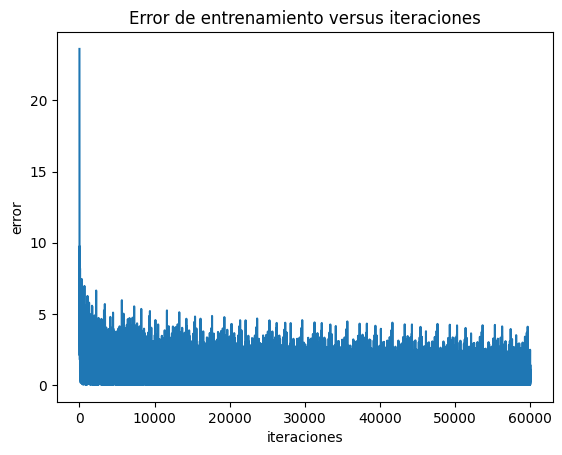

In [ ]:
# Graficar pérdidas
plt.plot(perdidas)
plt.title("Error de entrenamiento versus iteraciones")
plt.xlabel("iteraciones")
plt.ylabel("error")

print("Perdida entropía-cruzada en conjunto de test = {} \n".format(cross_entropy(x_test @ pesos_in + sesgo_in, y_test).item()))

In [ ]:
# Realizar predicciones y printear métricas
y_preds = predicciones(x_test @ pesos_in + sesgo_in)
print(classification_report(y_test.detach().numpy(), y_preds.detach().numpy(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.95      0.45      0.61      1000
           1       0.97      0.96      0.96      1000
           2       0.74      0.60      0.66      1000
           3       0.49      0.97      0.65      1000
           4       0.76      0.62      0.68      1000
           5       0.79      0.52      0.63      1000
           6       0.44      0.66      0.53      1000
           7       0.42      1.00      0.59      1000
           8       0.99      0.35      0.52      1000
           9       0.99      0.08      0.15      1000

    accuracy                           0.62     10000
   macro avg       0.75      0.62      0.60     10000
weighted avg       0.75      0.62      0.60     10000



### (d)

In [ ]:
# Función de la clase auxiliar

class Reg_Logistica(nn.Module):
  """Clase del modelo regresión logística.
  """
  def __init__(self,dim,num_class):
    super().__init__()
    self.lineal = nn.Linear(dim,num_class)

  def forward(self, xb):
    return self.lineal(xb)

In [ ]:
def entrenar(metodo_optim, modelo, epochs, batch_size=10):
  """Realiza el entrenamiento de un modelo mediante un optimizador
      y el método descenso gradiente mini batch.

  Parameters
  ----------
  metodo_optim : torch.optim
    Optimizador que usará la función entrenar

  modelo : torch.nn
    Modelo que se usa para obtener predicciones

  epochs : int
    Número de epocas que se realizan

  batch_size : int
    Cardinal de cada subconjunto batch

  Returns
  -------
  perdidas: list
    Lista con las pérdidas de todas las epocas
  """
  # Guardar pérdidas
  perdidas = []
  # Inicializar pesos y sesgo
  pesos = pesos_in
  pesos.requires_grad_()
  sesgo = sesgo_in
  # Recorrer número de epocas
  for e in range(epochs):
    # Guardar pérdida por epoca
    perdidas_epoch = []
    # cantidad de subconjuntos
    cantidad_batches = int(len(x_train)/batch_size)

    # --------- Descenso de gradiente mini barch -----------#
    for i in range(cantidad_batches):
      # calcular índices de conjuntos batch.
      start_i = i * batch_size
      end_i = start_i + batch_size
      # subconjunto bacth de X e y
      xb = x_train[start_i:end_i]
      yb = y_train[start_i:end_i]
      # Calcular predicción
      pred = modelo(xb)
      # Calcular pérdida
      loss = cross_entropy(pred, yb)
      loss.backward()
      # Actualizar parámetros
      metodo_optim.step()
      metodo_optim.zero_grad()
      perdidas_epoch.append(loss.item())
    # -------------------------------------------------------#

    # Agergar pérdida
    perdidas += perdidas_epoch
    # Printear progreso
    print("epoca {} de {}, training loss = {}".format(e+1,epochs,perdidas[-1]))
  return perdidas

In [ ]:
# Modelo y optimizador a usar
modelo = Reg_Logistica(dim=784, num_class=10)
opt_SGD = optim.SGD(modelo.parameters(), lr=0.1)

In [ ]:
# Iniciar reg logistica con descenso gradiente mini batch
perdidas_2 = entrenar(opt_SGD, modelo, epochs=10, batch_size=10)

epoca 1 de 10, training loss = 0.41702741384506226
epoca 2 de 10, training loss = 0.3854835629463196
epoca 3 de 10, training loss = 0.3714229166507721
epoca 4 de 10, training loss = 0.35785529017448425
epoca 5 de 10, training loss = 0.3452374339103699
epoca 6 de 10, training loss = 0.33389943838119507
epoca 7 de 10, training loss = 0.32387882471084595
epoca 8 de 10, training loss = 0.3150959610939026
epoca 9 de 10, training loss = 0.3074439764022827
epoca 10 de 10, training loss = 0.30081629753112793


Perdida entropía-cruzada en conjunto de test = 0.5398494601249695 



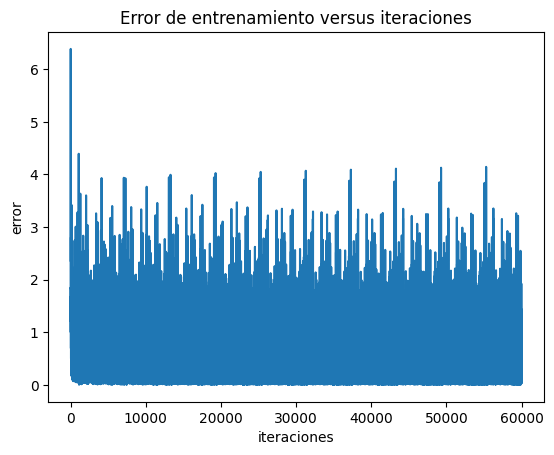

In [ ]:
# Graficar pérdidas
plt.plot(perdidas_2)
plt.title("Error de entrenamiento versus iteraciones")
plt.xlabel("iteraciones")
plt.ylabel("error")

print("Perdida entropía-cruzada en conjunto de test = {} \n".format(cross_entropy(modelo(x_test),y_test).item()))

In [ ]:
# Realizar predicciones y printear métricas
y_preds_2 = predicciones(modelo(x_test))
print(classification_report(y_test.detach().numpy(), y_preds_2.detach().numpy(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

              precision    recall  f1-score   support

           0       0.99      0.41      0.58      1000
           1       1.00      0.87      0.93      1000
           2       0.81      0.60      0.69      1000
           3       0.57      0.96      0.71      1000
           4       0.78      0.69      0.74      1000
           5       0.96      0.39      0.56      1000
           6       0.49      0.75      0.59      1000
           7       0.44      1.00      0.61      1000
           8       0.97      0.84      0.90      1000
           9       0.99      0.31      0.47      1000

    accuracy                           0.68     10000
   macro avg       0.80      0.68      0.68     10000
weighted avg       0.80      0.68      0.68     10000



epoca 1 de 10, training loss = 0.29187214374542236
epoca 2 de 10, training loss = 0.25790834426879883
epoca 3 de 10, training loss = 0.24839076399803162
epoca 4 de 10, training loss = 0.24451713263988495
epoca 5 de 10, training loss = 0.2422143667936325
epoca 6 de 10, training loss = 0.24035370349884033
epoca 7 de 10, training loss = 0.23860347270965576
epoca 8 de 10, training loss = 0.23687401413917542
epoca 9 de 10, training loss = 0.23515260219573975
epoca 10 de 10, training loss = 0.2334509789943695

 Perdida entropía-cruzada en conjunto de test = 0.4166416525840759 



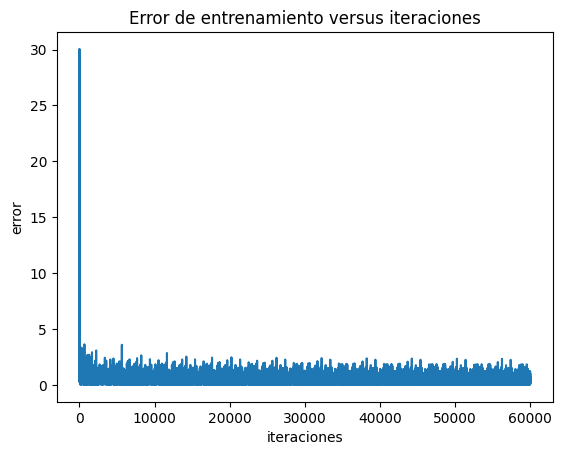


               precision    recall  f1-score   support

           0       0.84      0.77      0.80      1000
           1       0.99      0.94      0.97      1000
           2       0.81      0.71      0.76      1000
           3       0.74      0.94      0.83      1000
           4       0.82      0.69      0.75      1000
           5       0.81      0.69      0.74      1000
           6       0.62      0.61      0.62      1000
           7       0.50      1.00      0.66      1000
           8       0.82      0.98      0.89      1000
           9       0.99      0.13      0.23      1000

    accuracy                           0.74     10000
   macro avg       0.80      0.74      0.72     10000
weighted avg       0.80      0.74      0.72     10000



In [ ]:
#-------------- Repetición con optimizador Adagrad ---------------#

# Modelo y optimizador a usar
modelo = Reg_Logistica(dim=784, num_class=10)
opt_Adagrad = optim.Adagrad(modelo.parameters(), lr=0.1)

# Iniciar reg logistica con descenso gradiente mini batch
perdidas_3 = entrenar(opt_Adagrad, modelo, epochs=10, batch_size=10)

# Graficar pérdidas
plt.plot(perdidas_3)
plt.title("Error de entrenamiento versus iteraciones")
plt.xlabel("iteraciones")
plt.ylabel("error")

print("\n Perdida entropía-cruzada en conjunto de test = {} \n".format(cross_entropy(modelo(x_test),y_test).item()))
plt.show()

# Realizar predicciones y printear métricas
y_preds_3 = predicciones(modelo(x_test))
print('\n', classification_report(y_test.detach().numpy(), y_preds_3.detach().numpy(), target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

### (e)

En esta sección es donde más tiempo toma la ejecución del notebook. Es por esto que, en caso de querer ejecutar todo, se pueden cambiar hiperparámetros a gusto, e incluso usar gpu para acelerar los cálculos.

In [ ]:
# Usar datos con otras dimensiones definidas al inicio del notebook
print('dimensiones del conjunto de entrenamiento y prueba:')
x_train_reshape.shape, x_test_reshape.shape

dimensiones del conjunto de entrenamiento y prueba:


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [ ]:
# Cambiar conjunto de prueba con OneHotEncoding
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test)

In [ ]:
# Definir conjunto de validación (opcional)
train_X, valid_X, train_y, valid_y = train_test_split(x_train_reshape, train_Y_one_hot, test_size=0.2, random_state=13)

In [ ]:
# Hiperparámetros a utilizar
batch_size = 10
epochs = 10
num_classes = 10

In [ ]:
# Crear cnn con relu y max pooling
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1), padding='same'))
fashion_model.add(MaxPooling2D((2, 2), padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
fashion_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
fashion_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='relu'))
fashion_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Compilar modelo (optimizer = Adam())
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [ ]:
# Resumen de la cnn
fashion_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
# ------ ESTO DEMORA UNOS 26 MINUTOS -------#

# Entrenar con conjunto train y validar con conjunto valid
fashion_train = fashion_model.fit(x_train_reshape, train_Y_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_y))

Epoch 1/10
6000/6000 [==============================] - 160s 27ms/step - loss: 0.3862 - accuracy: 0.8581 - val_loss: 0.2700 - val_accuracy: 0.9055
Epoch 2/10
6000/6000 [==============================] - 157s 26ms/step - loss: 0.2532 - accuracy: 0.9072 - val_loss: 0.2127 - val_accuracy: 0.9237
Epoch 3/10
6000/6000 [==============================] - 175s 29ms/step - loss: 0.2162 - accuracy: 0.9198 - val_loss: 0.1690 - val_accuracy: 0.9358
Epoch 4/10
6000/6000 [==============================] - 162s 27ms/step - loss: 0.1883 - accuracy: 0.9299 - val_loss: 0.1557 - val_accuracy: 0.9429
Epoch 5/10
6000/6000 [==============================] - 159s 26ms/step - loss: 0.1676 - accuracy: 0.9377 - val_loss: 0.1383 - val_accuracy: 0.9476
Epoch 6/10
6000/6000 [==============================] - 158s 26ms/step - loss: 0.1506 - accuracy: 0.9441 - val_loss: 0.1310 - val_accuracy: 0.9509
Epoch 7/10
6000/6000 [==============================] - 162s 27ms/step - loss: 0.1326 - accuracy: 0.9498 - val_loss: 0

In [ ]:
# Printear pérdida y accuracy en conjunto test
test_eval = fashion_model.evaluate(x_test_reshape, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.31953638792037964
Test accuracy: 0.914900004863739


In [ ]:
# Predecir y printear métricas
predicted_classes = fashion_model.predict(x_test_reshape)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
print(classification_report(y_test, predicted_classes, target_names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

313/313 [==============================] - 8s 23ms/step
              precision    recall  f1-score   support

           0       0.80      0.88      0.83      1000
           1       0.99      0.98      0.99      1000
           2       0.82      0.92      0.87      1000
           3       0.93      0.91      0.92      1000
           4       0.89      0.81      0.85      1000
           5       0.99      0.97      0.98      1000
           6       0.82      0.73      0.77      1000
           7       0.96      0.96      0.96      1000
           8       0.98      0.99      0.99      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

